### Mounting drive
- worked on colab for faster computation

In [1]:
from google.colab import drive
drive.mount('/colab')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /colab


### Copying the folder from drive

In [0]:
!cp -r "/colab/My Drive/Vision_task_dataset_public" "./"

### Importing the required libraries

In [0]:
# reading the dateset
import pickle

# handling arrays
import numpy as np

# monitoring the progress of for loops
from tqdm import tqdm

#converting the labels into onehot encoding
from sklearn.preprocessing import OneHotEncoder

# for performing train-test split
from sklearn.model_selection import train_test_split as tts

# library to plot graphs and images
from matplotlib import pyplot as plt

# for shuffling the data
from sklearn.utils import shuffle

# opencv library to work with images and perform certain operations
import cv2

### Reading the files

In [0]:
with open('Vision_task_dataset_public/train_image.pkl', 'rb') as file:
    train_data = pickle.load(file)
    
with open('Vision_task_dataset_public/train_label.pkl', 'rb') as file:
    train_label = pickle.load(file)

In [56]:
# getting to know the data
print(type(train_data),len(train_data))
print(len(train_data[0]))

<class 'list'> 8000
784


In [0]:
# converting into required shape
train_data = np.array(train_data).reshape(-1,28,28,1)

### Visualising the images

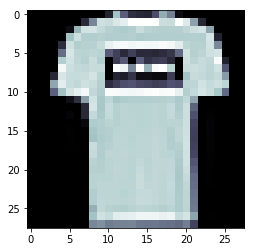

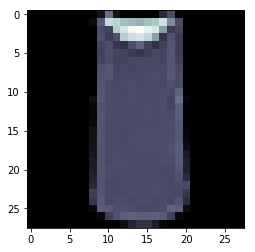

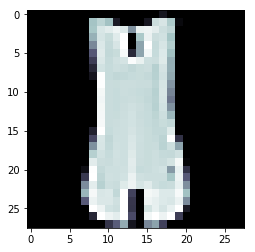

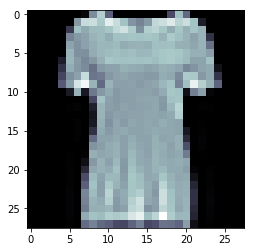

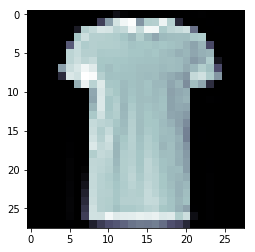

In [58]:
for i in range(5):
  plt.imshow(train_data[i].reshape(28,28),cmap = plt.cm.bone) #used cmap to sharpen the images
  plt.show()

### Analysing data distribution

In [59]:
train_label = np.array(train_label).reshape(-1,1)
np.unique(train_label,return_counts=True)  #finding unique labels and their counts

(array([0, 2, 3, 6]), array([2000, 2000, 2000, 2000]))

### One hot-encoding the labels

In [60]:
enc = OneHotEncoder(handle_unknown='ignore',sparse=True)
train_label = enc.fit_transform(train_label).toarray()
print(train_label.shape)
print(train_label[:5])

(8000, 4)
[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]


### Splitting the data into train and test
- we dont perform any operation on test images
- performed 90-10 split

In [0]:
x_train,x_test,y_train,y_test = tts(train_data,train_label,random_state = 5,test_size = 0.1,shuffle = True)

### Data Augmentation
- 8000 images are not enough to train the model
- Performing data augmentation will improve our models considerably
- Techniques performed are:

        flipping
        rotating
        shifting 

In [11]:
M = np.float32([[1, 0, 6], [0, 1, 6]])
M1 = cv2.getRotationMatrix2D((14,14),90,1)

augmented_images = []
augmented_y = []

for i in tqdm(range(len(x_train))):
  x = x_train[i]
  x=x.astype(np.float32)
  y = y_train[i]
  # flipping the image left-right
  x1 = np.fliplr(x)  
  #flipping the image up-down
  x2 = np.flipud(x)
  #rotating 90 degrees
  x3 = np.rot90(x,1,(0,1))
  #rotating 180 degrees
  x4 = np.rot90(x3,1,(0,1))
  #rotating 270 degrees
  x5 = np.rot90(x4,1,(0,1))
  #shifting the image and rotating the image
  x6 = cv2.warpAffine(x,M1,(28,28)).reshape(28,28,1)
  #shifting the image
  x7 = cv2.warpAffine(x, M, (28, 28)).reshape(28,28,1)
  #flipping the rotated image
  x8 = np.flipud(x6).reshape(28,28,1)
  augmented_images.append(x1)
  augmented_images.append(x2)
  augmented_images.append(x3)
  augmented_images.append(x4)
  augmented_images.append(x5)
  augmented_images.append(x6)
  augmented_images.append(x7)
  augmented_images.append(x8)
  for j in range(8):
    augmented_y.append(y)

100%|██████████| 7200/7200 [00:00<00:00, 11732.72it/s]


### Adding Gaaussian Noise in the data
- Sometimes the data overfits because of data augmentation so gaussian noise is added
- Didnt work for the model, therefore it was removed

In [0]:
# mean = 0
# var = 0.2
# sigma = var**0.5
# for i in tqdm(range(1500)):
#   gauss = np.random.normal(mean,sigma,(28,28,1))
#   y = y_train[456+i]
#   augmented_images.append(gauss)
#   augmented_y.append(y)

In [13]:
len(augmented_images)

57600

### Joining original dataset with augmented data

In [0]:
augmented_images = np.array(augmented_images)
augmented_y = np.array(augmented_y)
x_train = np.concatenate((x_train,augmented_images),axis=0)
y_train = np.concatenate((y_train,augmented_y),axis=0)

### Shuffling the data as the original dataset and augmented data is in order

In [0]:
x_train, y_train = shuffle(x_train, y_train, random_state=42)

In [16]:
x_train.shape,y_train.shape,x_test.shape,y_test.shape

((64800, 28, 28, 1), (64800, 4), (800, 28, 28, 1), (800, 4))

### Function for plotting model accuracies and losses

In [0]:
def func(history):

  # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()


    plt.show()

### Importing the required keras libraries

In [0]:
from keras import Model
from keras.models import Sequential                                 #type of model
from keras.layers import Dropout, Dense, Flatten, Convolution2D, Activation, BatchNormalization, MaxPool2D  #layers in keras model
from keras.layers.advanced_activations import LeakyReLU            #activation layer
from keras.callbacks import ModelCheckpoint

### Keras model

### Layers used
- convolution2d : main layer in cnn, helps in training images
- batchnormalisation : mean normalise the activations of previous layer. Important to prevent gradient from exploding
- LeakyRelu : its a leaky version of relu, allows small gradients when the unit is not active
- Maxpooling2d : reduces the size of images by taking the maximum in image. helps to extract features from the image
- flatten : converts 2D array to 1 D to pass through dense layer
- dense : normal fully connected layers to apply activation
- dropout : to reduce overfitting

### Compile Function
- Loss used -> categorical_crossentropy (for multiclass classification)
- Optimizer -> adam (one of the best optimizer in keras)

### Model 1
- used a model I used on a different dataset
- less layers to see how the model performs

In [19]:
model1 = Sequential()

model1.add(Convolution2D(16, (3,3), padding='same', use_bias=False, input_shape=(28,28,1)))
model1.add(BatchNormalization())
model1.add(LeakyReLU(alpha=0.1))
model1.add(MaxPool2D(pool_size=(2, 2)))

model1.add(Convolution2D(32, (3,3), padding='same', use_bias=False))
model1.add(BatchNormalization())
model1.add(LeakyReLU(alpha=0.1))
model1.add(MaxPool2D(pool_size=(2, 2)))

model1.add(Convolution2D(64, (3,3),padding='same', use_bias=False))
model1.add(BatchNormalization())
model1.add(LeakyReLU(alpha=0.1))
model1.add(MaxPool2D(pool_size=(2, 2)))

model1.add(Convolution2D(64, (3,3), padding='same',use_bias=False))
model1.add(BatchNormalization())
model1.add(LeakyReLU(alpha=0.1))
          
model1.add(Flatten())
model1.add(Dense(100,activation='relu'))
model1.add(Dropout(0.2))
model1.add(Dense(4,activation='softmax'))

#printing the model summary
print(model1.summary())

#compiling the model with optimizer adam, and metrics as accuracy
model1.compile(optimizer = 'adam',loss = 'categorical_crossentropy', metrics = ['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 16)        144       
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 16)        64        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 28, 28, 16)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        4608      
_________________________________________________________________
batch_normalization_2

In [20]:
X1 = model1.fit(x_train,y_train,batch_size=128,epochs=50,validation_split=0.1)

Instructions for updating:
Use tf.cast instead.
Train on 58320 samples, validate on 6480 samples
Epoch 1/50
58320/58320 [==============================] - 11s 187us/step - loss: 0.5759 - acc: 0.7689 - val_loss: 0.6879 - val_acc: 0.7500
Epoch 2/50
58320/58320 [==============================] - 7s 123us/step - loss: 0.4100 - acc: 0.8392 - val_loss: 0.4061 - val_acc: 0.8380
Epoch 3/50
58320/58320 [==============================] - 7s 124us/step - loss: 0.3584 - acc: 0.8593 - val_loss: 0.3991 - val_acc: 0.8460
Epoch 4/50
58320/58320 [==============================] - 7s 124us/step - loss: 0.3266 - acc: 0.8720 - val_loss: 0.3638 - val_acc: 0.8622
Epoch 5/50
58320/58320 [==============================] - 7s 125us/step - loss: 0.2948 - acc: 0.8837 - val_loss: 0.4233 - val_acc: 0.8381
Epoch 6/50
58320/58320 [==============================] - 8s 131us/step - loss: 0.2685 - acc: 0.8936 - val_loss: 0.3632 - val_acc: 0.8622
Epoch 7/50
58320/58320 [==============================] - 7s 128us/step - 

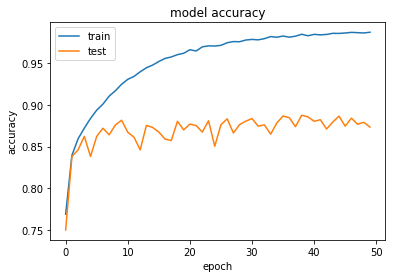

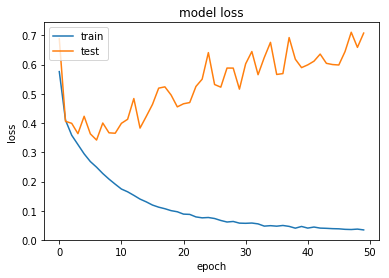

800/800 [==============================] - 0s 115us/step
Test accuracy :  0.8525


In [21]:
func(X1) #plotting the graphs
_,acc = model1.evaluate(x_test,y_test)
print("Test accuracy : ",acc)

### Model 2
- did some changes to model 1
- removed leakyrelu and added normal relu
- increased the number of units and layers

In [22]:
model2 = Sequential()

model2.add(Convolution2D(16, (3,3), padding='same', activation = 'relu',use_bias=False, input_shape=(28,28,1)))
model2.add(BatchNormalization())
# model1.add(LeakyReLU(alpha=0.1))
model2.add(MaxPool2D(pool_size=(2, 2)))
model2.add(Dropout(0.2))

model2.add(Convolution2D(32, (3,3), padding='same', activation = 'relu',use_bias=False))
model2.add(BatchNormalization())
# model1.add(LeakyReLU(alpha=0.1))
model2.add(MaxPool2D(pool_size=(2, 2)))
model2.add(Dropout(0.2))

model2.add(Convolution2D(64, (3,3),padding='same', activation = 'relu',use_bias=False))
model2.add(BatchNormalization())
# model1.add(LeakyReLU(alpha=0.1))
model2.add(MaxPool2D(pool_size=(2, 2)))
model2.add(Dropout(0.2))

model2.add(Convolution2D(128, (3,3), padding='same',activation = 'relu',use_bias=False))
model2.add(BatchNormalization())
# model1.add(LeakyReLU(alpha=0.1))
model2.add(Dropout(0.2))

model2.add(Flatten())
model2.add(Dense(250,activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(4,activation='softmax'))
print(model2.summary())
model2.compile(optimizer = 'adam',loss = 'categorical_crossentropy', metrics = ['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 28, 28, 16)        144       
_________________________________________________________________
batch_normalization_5 (Batch (None, 28, 28, 16)        64        
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 32)        4608      
_________________________________________________________________
batch_normalization_6 (Batch (None, 14, 14, 32)        128       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 32)          0         
__________

In [23]:
X2 = model2.fit(x_train,y_train,batch_size=128,epochs=50,validation_split=0.1)

Train on 58320 samples, validate on 6480 samples
Epoch 1/50
58320/58320 [==============================] - 9s 150us/step - loss: 0.7190 - acc: 0.7029 - val_loss: 0.5143 - val_acc: 0.7927
Epoch 2/50
58320/58320 [==============================] - 8s 129us/step - loss: 0.5304 - acc: 0.7885 - val_loss: 0.4321 - val_acc: 0.8287
Epoch 3/50
58320/58320 [==============================] - 8s 129us/step - loss: 0.4746 - acc: 0.8097 - val_loss: 0.4021 - val_acc: 0.8429
Epoch 4/50
58320/58320 [==============================] - 7s 128us/step - loss: 0.4393 - acc: 0.8237 - val_loss: 0.4424 - val_acc: 0.8196
Epoch 5/50
58320/58320 [==============================] - 7s 128us/step - loss: 0.4175 - acc: 0.8347 - val_loss: 0.4382 - val_acc: 0.8245
Epoch 6/50
58320/58320 [==============================] - 8s 129us/step - loss: 0.4010 - acc: 0.8412 - val_loss: 0.3698 - val_acc: 0.8552
Epoch 7/50
58320/58320 [==============================] - 8s 129us/step - loss: 0.3858 - acc: 0.8463 - val_loss: 0.3438 - v

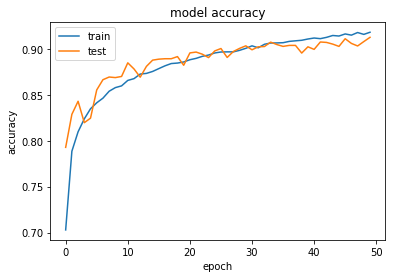

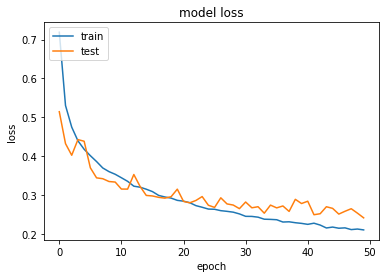

800/800 [==============================] - 0s 114us/step
Test Accuracy :  0.88625


In [24]:
func(X2)
_,acc = model2.evaluate(x_test,y_test)
print("Test Accuracy : ",acc)

### Model 3
- added more layers units
- increased dropout layers as the model was overfitting

In [30]:
model3 = Sequential()

model3.add(Convolution2D(32,(3,3),padding = 'Same',activation ='relu', input_shape = (28,28,1)))
model3.add(BatchNormalization())

model3.add(Convolution2D(64,(3,3),padding = 'Same',activation ='relu'))
model3.add(BatchNormalization())
model3.add(MaxPool2D(pool_size=(2,2)))
model3.add(Dropout(0.4))

model3.add(Convolution2D(96,(3,3),padding = 'Same',activation ='relu'))
model3.add(BatchNormalization())
    
model3.add(Convolution2D(128,(3,3),padding = 'Same',activation ='relu'))
model3.add(BatchNormalization())
model3.add(MaxPool2D(pool_size=(2,2)))
model3.add(Dropout(0.4))

model3.add(Flatten())

model3.add(Dense(512,activation='relu'))
model3.add(BatchNormalization())
model3.add(Dropout(0.4))

model3.add(Dense(64,activation='relu'))
model3.add(BatchNormalization())
model3.add(Dropout(0.4))
model3.add(Dense(4,activation='softmax'))

#saving the weights of the model after every improvement
checkpoint = ModelCheckpoint("./weights-loss-{val_loss:.5f}-acc-{val_acc:.5f}.h5", monitor='val_loss', verbose=1,save_best_only = True, save_weights_only=True)
callbacks_list = [checkpoint]


model3.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_27 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 28, 28, 64)        18496     
_________________________________________________________________
batch_normalization_28 (Batc (None, 28, 28, 64)        256       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 14, 14, 96)        55392     
__________

In [31]:
X3 = model3.fit(x_train,y_train,epochs=50,batch_size=128,validation_split = 0.1,callbacks=callbacks_list)

Train on 58320 samples, validate on 6480 samples
Epoch 1/50
58320/58320 [==============================] - 28s 484us/step - loss: 0.6939 - acc: 0.7301 - val_loss: 0.4478 - val_acc: 0.8264

Epoch 00001: val_loss improved from inf to 0.44779, saving model to ./weights-loss-0.44779-acc-0.82639.h5
Epoch 2/50
58320/58320 [==============================] - 26s 438us/step - loss: 0.4652 - acc: 0.8213 - val_loss: 0.3865 - val_acc: 0.8534

Epoch 00002: val_loss improved from 0.44779 to 0.38647, saving model to ./weights-loss-0.38647-acc-0.85340.h5
Epoch 3/50
58320/58320 [==============================] - 26s 441us/step - loss: 0.4114 - acc: 0.8403 - val_loss: 0.3321 - val_acc: 0.8741

Epoch 00003: val_loss improved from 0.38647 to 0.33213, saving model to ./weights-loss-0.33213-acc-0.87407.h5
Epoch 4/50
58320/58320 [==============================] - 26s 439us/step - loss: 0.3796 - acc: 0.8530 - val_loss: 0.3284 - val_acc: 0.8762

Epoch 00004: val_loss improved from 0.33213 to 0.32836, saving mo

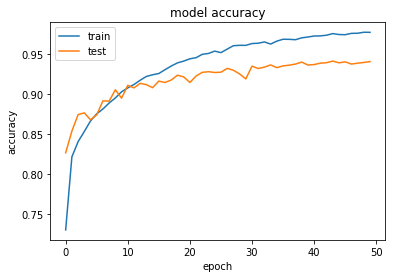

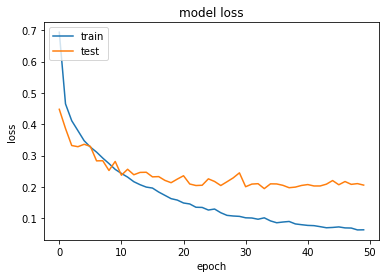

800/800 [==============================] - 0s 264us/step
Test Accuracy :  0.91125


In [42]:
func(X3)
_, acc = model3.evaluate(x_test,y_test)
print("Test Accuracy : ", acc)

### Training with the complete model

#### Augmenting the whole dataset

In [62]:
M = np.float32([[1, 0, 6], [0, 1, 6]])
M1 = cv2.getRotationMatrix2D((14,14),90,1)

augmented_images = []
augmented_y = []

for i in tqdm(range(len(train_data))):
  x = train_data[i]
  x=x.astype(np.float32)
  y = train_label[i]
  # flipping the image left-right
  x1 = np.fliplr(x)  
  #flipping the image up-down
  x2 = np.flipud(x)
  #rotating 90 degrees
  x3 = np.rot90(x,1,(0,1))
  #rotating 180 degrees
  x4 = np.rot90(x3,1,(0,1))
  #rotating 270 degrees
  x5 = np.rot90(x4,1,(0,1))
  #shifting the image and rotating the image
  x6 = cv2.warpAffine(x,M1,(28,28)).reshape(28,28,1)
  #shifting the image
  x7 = cv2.warpAffine(x, M, (28, 28)).reshape(28,28,1)
  #flipping the rotated image
  x8 = np.flipud(x6).reshape(28,28,1)
  augmented_images.append(x1)
  augmented_images.append(x2)
  augmented_images.append(x3)
  augmented_images.append(x4)
  augmented_images.append(x5)
  augmented_images.append(x6)
  augmented_images.append(x7)
  augmented_images.append(x8)
  for j in range(8):
    augmented_y.append(y)

100%|██████████| 8000/8000 [00:00<00:00, 13835.53it/s]


In [0]:
#adding the augmented images to the original images
train_data = np.concatenate((train_data,np.array(augmented_images)),axis=0)
train_label = np.concatenate((train_label,np.array(augmented_y)),axis=0)

In [64]:
train_data.shape,train_label.shape

((72000, 28, 28, 1), (72000, 4))

In [66]:
# using the 3rd model with complete data
model3.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
print(model3.summary())
X4 = model3.fit(train_data,train_label,epochs=50,batch_size=128)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_29 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_39 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 28, 28, 64)        18496     
_________________________________________________________________
batch_normalization_40 (Batc (None, 28, 28, 64)        256       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_27 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 14, 14, 96)        55392     
__________

### Predicting the test data

In [81]:
#reading the files
with open('Vision_task_dataset_public/test_image.pkl', 'rb') as file:
    test_data = pickle.load(file)
#checking the type of data 
print(type(test_data),len(test_data))
print(len(test_data[0]))

<class 'list'> 2000
784


In [0]:
# converting into required shape
test_data = np.array(test_data).reshape(-1,28,28,1)

In [0]:
# predicting for the test array
pred = model3.predict(test_data)
pred = np.argmax(pred,axis=1)

In [84]:
 #the list of classes as found by the one hot encoder
print(enc.categories_)
type(enc.categories_)

[array([0, 2, 3, 6])]


list

In [0]:
#the list containing the classes
flag = [0, 2, 3, 6]

In [0]:
#preparing the numpy array to be written into csv
write = np.zeros(shape=(2000, 2))
for i in range(len(pred)):
    write[i][0] = int(i)
    write[i][1] = int(flag[pred[i]])

In [0]:
# store predictions to a csv file
import pandas as pd
pd.DataFrame(write).to_csv("Utkarsh_Tyagi.csv",header=['image_index','class'], index=False)

In [0]:
#copying the csv from colab to drive
!cp -r "Utkarsh_Tyagi.csv" "/colab/My Drive/"